In [1]:
## import necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

In [2]:
## reading data into pandas dataframe object
data = pd.read_csv('Dataset_Uber Traffic.csv')

In [3]:
## Checking the first five rows of data
data.head()

,DateTime,Junction,Vehicles,ID
0,01/11/15 0:00,1,15,20151101001
1,01/11/15 1:00,1,13,20151101011
2,01/11/15 2:00,1,10,20151101021
3,01/11/15 3:00,1,7,20151101031
4,01/11/15 4:00,1,9,20151101041


In [4]:
## Checking the number of records and number of features
data.shape

(48120, 4)

In [5]:
## Removing any missing values if any
data_cleaned = data.dropna()

In [6]:
## Removing any duplicate values if any
data_cleaned = data_cleaned.drop_duplicates()

In [7]:
data_cleaned.shape

(48120, 4)

In [8]:
## Ensuring correct datatypes
data_cleaned['Junction'] = data_cleaned['Junction'].astype(int)
data_cleaned['Vehicles'] = data_cleaned['Vehicles'].astype(int)
data_cleaned['DateTime'] = pd.to_datetime(data_cleaned['DateTime'])

In [9]:
## Group by DateTime (hourly) and Junction to get total vehicles per hour per junction
data_aggregated = data_cleaned.groupby(['DateTime', 'Junction']).agg({'Vehicles': 'sum'}).reset_index()

In [10]:
## Creating time-based features
data_aggregated['Hour'] = data_aggregated['DateTime'].dt.hour
data_aggregated['Day'] = data_aggregated['DateTime'].dt.day
data_aggregated['Weekday'] = data_aggregated['DateTime'].dt.weekday
data_aggregated['Month'] = data_aggregated['DateTime'].dt.month
data_aggregated['Year'] = data_aggregated['DateTime'].dt.year

In [11]:
## Creating binary indicator for weekends
data_aggregated['IsWeekend'] = data_aggregated['Weekday'].isin([5, 6]).astype(int)

In [12]:
## Creating Lag features for 1 hour and 24 hours before
data_aggregated.sort_values(['Junction', 'DateTime'], inplace=True)
data_aggregated['Lag_1hr'] = data_aggregated.groupby('Junction')['Vehicles'].shift(1)
data_aggregated['Lag_24hr'] = data_aggregated.groupby('Junction')['Vehicles'].shift(24)

In [13]:
# Dropping any rows with NaN values created due to lag features
data_aggregated.dropna(inplace=True)

In [14]:
## Defining features and target
feature_cols = ['Hour', 'Day', 'Weekday', 'Month', 'Year', 'Junction', 'IsWeekend', 'Lag_1hr', 'Lag_24hr']
X = data_aggregated[feature_cols]
y = data_aggregated['Vehicles']

In [15]:
## Normalizing features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

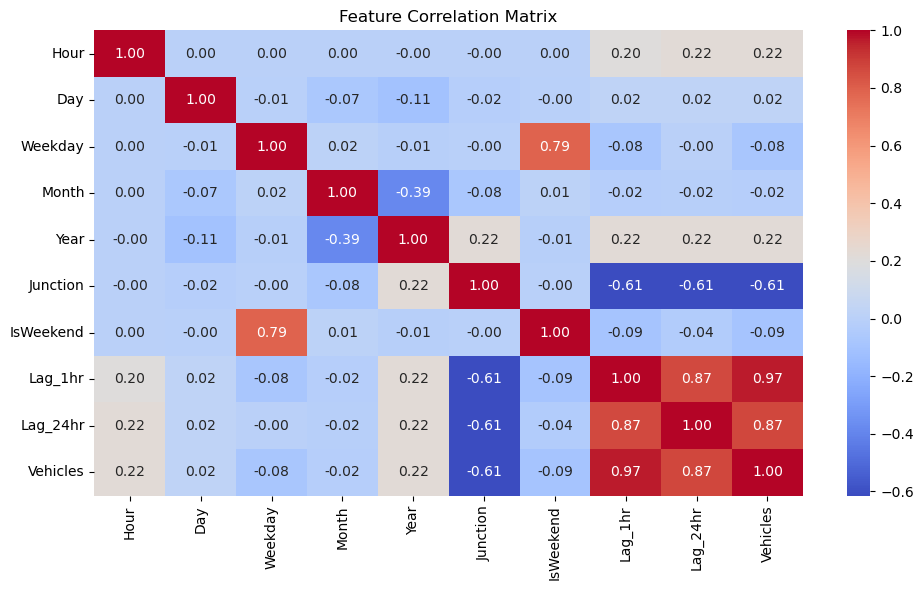

In [16]:
## Computing Correlation matrix
correlation_matrix = data_aggregated[feature_cols + ['Vehicles']].corr()

## Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

In [17]:
## Fitting Random Forest for feature importance
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_scaled, y)

RandomForestRegressor(random_state=42)

In [18]:
## Extracting Feature Importance
importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(importance_df)

     Feature  Importance
7    Lag_1hr    0.941197
0       Hour    0.020610
8   Lag_24hr    0.013563
1        Day    0.008627
3      Month    0.005874
2    Weekday    0.004151
5   Junction    0.003497
4       Year    0.001833
6  IsWeekend    0.000646


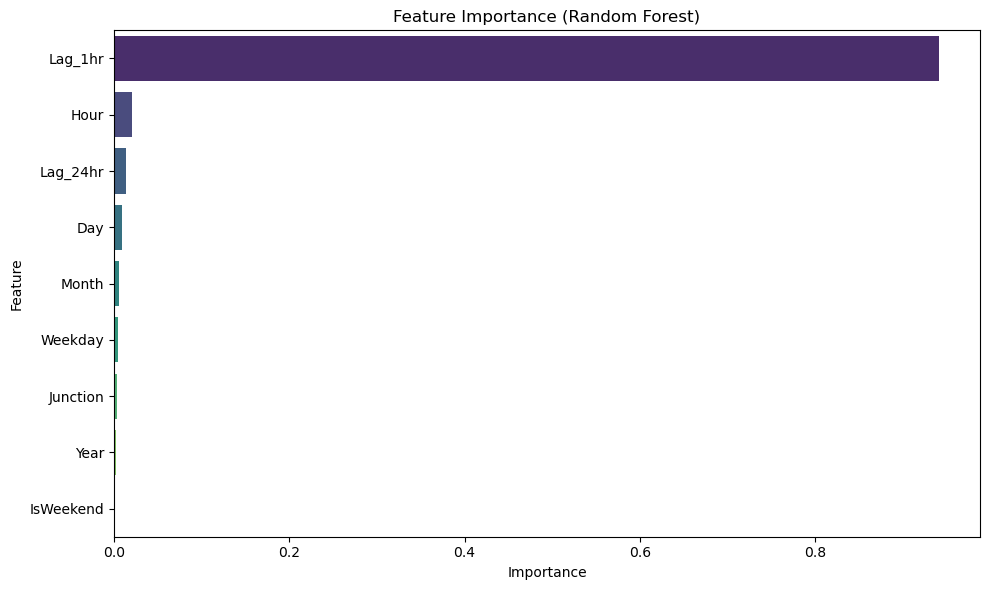

In [19]:
## Plotting Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()